# Taking Titanic Further
The previously explored beginner Titanic ML tutorial covered a basic implementation of using a Random Forest model to predict the survival of passengers onboard the Titanic. It took into account some features: passenger class, sex, siblings/partners, and parents/children, however, another important feature it did not account for is age. This ML project integrates this, as well as other features.

# Model Selection
Factors to consider in model selection for this challenge are:

- Moderately-sized dataset (891 rows, 12 columns)
- Binary classification.
- Potential for interaction effects. E.g. female AND old != female, old.
- Non-linear response of prediction to features. E.g. young or elderly may survive, while middle-aged may not.

Some common examples of models suitable for binary classification are: Logistic Regression, Random Forest, XGBoost, kNN, SVM, etc. Given the non-linearity and small size of the dataset, Random Forest is a sensible choice.

# Cross Validation
To compare the performance of different models, cross-validation is used. Given the size of the dataset, K-fold cross-validation is suitable, which will need to be stratified given that there may not be an equal number of survivors and non-survivors. Since the dataset is quite small, the training set will be split into 5-folds

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold

In [2]:
# Import training and testing data and view

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
print(train_data.shape)
train_data.head()


(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis
It's first helpful to see how many survived and how many did not. Since there are more that did not survive, it is useful to use a stratified K-fold cross-validation, to ensure that each fold receives a similar number of passengers that survived and didn't survive.

Next, we check if there is any missing data that should either be excluded or imputed. Below, we see that Cabin is seldom provided for the passengers, so can be excluded as a feature. Age is missing for ~19% of passengers, so we can impute this using the median. Embarked is only missing for two passengers, so these can be dropped if needed.

In [3]:
train_data['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [4]:
print(len(train_data))
train_data.isnull().sum()

891


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
train_data.dropna(subset=['Embarked'],inplace=True)
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

# Passenger Class and Sex are Important
The graphs below show how Sex and Pclass have major influence on the chance of survival. Passengers more likely to survive were **female** and/or in **1st class**.

Text(0.5, 1.0, 'Passengers survived by Passenger Class')

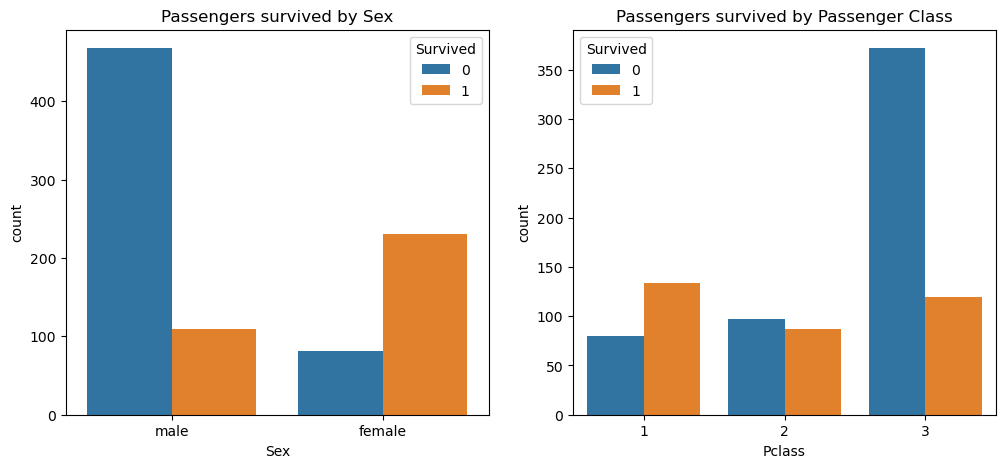

In [6]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

sns.countplot(data=train_data,x='Sex',hue='Survived', ax = axes[0])
axes[0].set_title('Passengers survived by Sex')

sns.countplot(data=train_data,x='Pclass',hue = 'Survived', ax = axes[1])
axes[1].set_title('Passengers survived by Passenger Class')

# Family plays a major part
Family size can be calculated by summing up the number of siblings/spouses and parents/children. The graphs below show that very young children (0-5 yrs) mostly survived, and people with family sizes of 2-4 also mostly survived. Single people and large families fared much worse.

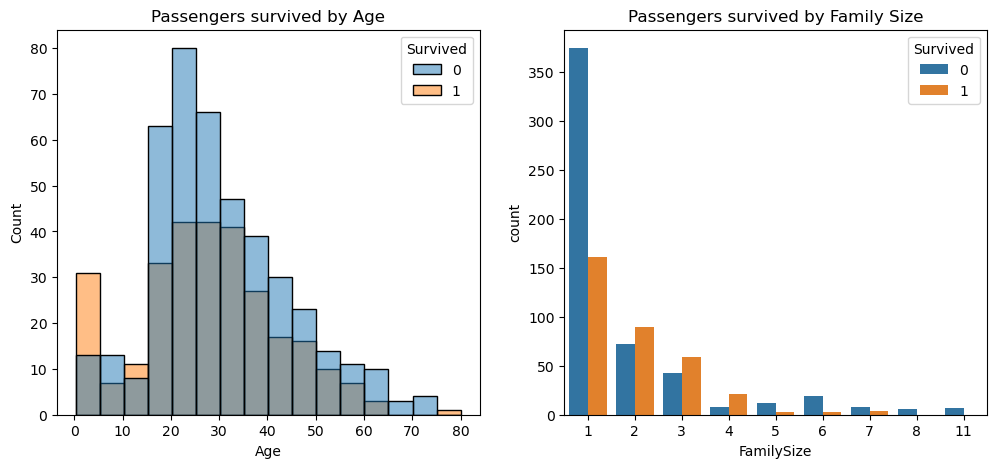

In [7]:
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1

fig, axes = plt.subplots(1,2, figsize=(12,5))

sns.histplot(data=train_data,x='Age',hue='Survived',binwidth=5, ax = axes[0])
axes[0].set_title('Passengers survived by Age')

sns.countplot(data=train_data,x='FamilySize',hue = 'Survived', ax = axes[1])
axes[1].set_title('Passengers survived by Family Size')



plt.show()

# Random Forest
A random forest model is well-suited to this problem because, unlike logistic regression, tree-based models naturally capture non-linear relationships. For example, survival rates may be highest for both young children and older passengers, with lower rates for middle-aged adults. Additionally, a logistic regression cannot account for interactions between features, instead requiring further feature engineering.

Below, a model is created which implements most of the key features shown to have impact in the EDA. Age was excluded in this first model, as Random Forest cannot handle null values. To 

In [8]:
# Define features, model, X, and y for the base model

features_base = ['Pclass','Fare','Sex','SibSp','Parch','FamilySize','Embarked']
model_base = RandomForestClassifier(n_estimators=100,max_depth=5,random_state=1)

y = train_data['Survived']

# get_dummies transforms categorical data into numeric

X_train_base = pd.get_dummies(train_data[features_base]) 

# Define cross-validation method as a repeated stratified k-fold CV

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)

predictions_base = cross_val_score(model_base,X_train_base,y,cv=cv)

print(f'{round(predictions_base.mean()*100,2)} +- {round(predictions_base.std()*100,2)}%')

80.38 +- 2.83%


# Adding Age as a Feature
Now we can build on this model by also incorporating age. Since almost 20% of the passengers in the training data are missing their age, it is not suitable to drop these passengers and instead the values should be imputed. The median age is imputed, so that extreme values do not skew the average.

In [9]:
# Defining the features and pipeline (imputer) of the second ML model

features_age = ['Pclass','Fare','Sex','Age','SibSp','Parch','FamilySize','Embarked']
pipe_age = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('model', RandomForestClassifier(n_estimators=100,max_depth=5,random_state=1))])

X_train_age = pd.get_dummies(train_data[features_age])

predictions_age = cross_val_score(pipe_age,X_train_age,y,cv=cv)

print(f'{round(predictions_age.mean()*100,2)} +- {round(predictions_age.std()*100,2)}%')

82.14 +- 2.76%


# Extracting Title as a Feature
Another method to extract some information about the passengers is to consider their Title. While it can extract some redundant features, such as their Sex, it can also elucidate other attributes. It may reveal the rough age of passengers who otherwise did not have their age recorded, and passengers with unique Titles, such as Col, Don, or Capt, may indicate a status that influences their odds of survival. The title is extracted from their name.

In [10]:
# Extracting title from their title by splitting the string

train_data['Title'] = train_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
train_data['Title'].value_counts()

Title
Mr              517
Miss            181
Mrs             124
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [11]:
# Group all unique titles as 'VIP'

train_data['Title'] = train_data['Title'].apply(lambda title: title if title in ['Mr','Miss','Mrs','Master','Dr','Rev'] else 'VIP')
print(train_data['Title'].value_counts())

Title
Mr        517
Miss      181
Mrs       124
Master     40
VIP        14
Dr          7
Rev         6
Name: count, dtype: int64


In [12]:
# Create new model including title as a feature
 
features_title = ['Pclass','Fare','Sex','Age','SibSp','Parch','FamilySize','Embarked','Title']

X_train_title = pd.get_dummies(train_data[features_title])

prediction_title = cross_val_score(pipe_age,X_train_title,y,cv=cv)

print(f'{round(prediction_title.mean()*100,2)} +- {round(prediction_title.std()*100,2)}%')

83.1 +- 2.72%


# Results

1. Model excluding age: 80.38 +- 2.84%
2. Model imputing age: 82.07 +- 2.81%
3. **Model imputing age and adding title: 83.1 +- 2.72%**

In [13]:
def preprocess_data(df):
    df = df.copy()
    df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    df['Title'] = df['Title'].apply(lambda title: title if title in ['Mr','Miss','Mrs','Master','Dr','Rev'] else 'VIP')
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    return df

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_preprocessed = preprocess_data(train_data)
test_preprocessed = preprocess_data(test_data)

features_final = ['Pclass','Fare','Sex','Age','SibSp','Parch','FamilySize','Embarked','Title']

X_train_final = pd.get_dummies(train_preprocessed[features_final])
y = train_data['Survived']
X_test_final = pd.get_dummies(test_preprocessed[features_final])

pipe_final = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('model', RandomForestClassifier(n_estimators=100,max_depth=5,random_state=1))])

pipe_final.fit(X_train_final,y)
predictions_final = pipe_final.predict(X_test_final)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions_final})
output.to_csv('submission.csv', index=False)

# Conclusions
Exploratory data analysis showed that Passenger Class, Sex, and Age are some of the most important features in determining someone's chance of survival on the Titanic. Preprocessing involved the following:

- extracting Title from the passengers' Name
- calculating Total FamilySize using SibSp and Parch
- imputing Embarked values using the mode in the dataset.

Different ML models were tested and compared:

- Model 1 - model_base uses features ready to use in the dataset as is. 80.38 +- 2.84%
- Model 2 - pipe_age employs a pipeline which imputes median Age using the training data. 82.07 +- 2.81%
- Model 3 - same as Model 2 but adds Title as a feature. 83.1 +- 2.72%

Model 3 was chosen as the final model (pipe_final), giving the highest accuracy with lowest uncertainty. Ultimately, this gave a prediction accuracy of 0.77990, a minor improvement over the baseline model.

To improve the model moving forward:

- improve feature engineering. For example, impute age by using grouped medians, extract marital status, use cabin location
- try out different classification models. Logistic Regression, XGBoost, Naive Bayes, etc. 